### Overview

Implements and compares two numerical methods for solving a 1-D nonlinear boundary value problem (BVP):
$$y'' = λ (y − y³),     y(0) = −1,   y(1) = +1.$$

We used:
1. A finite-element method (FEM) using P1 linear elements with Newton’s method for the nonlinear system.
2. A shooting method using `solve_ivp` and scalar root-finding to match the right boundary.
3. A convergence test to verify correctness of the FEM solver.
4. A parameter sweep over λ to check solver robustness.

Each section contains a short explanation followed by the code used to implement that component.

In [1]:
import numpy as np
from numpy.linalg import solve, norm
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import time

We begin by setting up the finite element framework that we use for the nonlinear boundary value problem. The goal is to approximate the solution on a uniform mesh using linear basis functions. We first generate the mesh and assemble the global stiffness matrix and load vector for the linear part of the equation. We then build the nonlinear residual and the Jacobian that appear in the Newton iteration. These pieces allow us to treat the nonlinear term in a consistent way and apply Newton’s method in the space of nodal values.

After defining these components, we combine them into a complete FEM routine. This solver forms the residual, assembles the Jacobian, applies the boundary conditions, and carries out Newton iteration until the update converges. The output is the numerical solution on the chosen mesh. Ha


In [3]:
####### FEM Solver #######

# nonlinear term f(y) = y^3 - y
def f_nonlin(y):
    return y**3 - y

# FEM solver for –y'' + λ (y³ – y) = 0 using P1 linear elements
def solve_fem_toy_bvp(lam, N, y_left=-1.0, y_right=1.0, tol=1e-10, max_iter=20):
    
    # build uniform grid
    x = np.linspace(0.0, 1.0, N + 1)
    
    # element size (uniform)
    h = x[1] - x[0]
    
    # initial guess: linear interpolation between boundaries
    y_full = np.linspace(y_left, y_right, N + 1)
    
    # number of interior unknowns
    NI = N - 1
    
    # assemble global stiffness matrix K_full (size (N+1)x(N+1))
    K_full = np.zeros((N + 1, N + 1))
    for e in range(N):
        Ke = (1.0 / h) * np.array([[1.0, -1.0],
                                   [-1.0, 1.0]])
        K_full[e:e+2, e:e+2] += Ke
    
    # Gauss quadrature points and weights on [-1,1]
    xi_vec = np.array([-1.0/np.sqrt(3.0), 1.0/np.sqrt(3.0)])
    w_vec  = np.array([1.0, 1.0])
    
    # assemble nonlinear vector N_full(y)
    def assemble_N_full(y):
        N_full = np.zeros(N + 1)
        
        # loop over elements
        for e in range(N):
            i = e
            j = e + 1
            
            # local contributions
            Ne_local = np.zeros(2)
            
            # element length
            h_e = x[j] - x[i]
            
            # Jacobian from reference [-1,1] to [x_i,x_j]
            J = h_e / 2.0
            
            # loop over Gauss points
            for xi, w in zip(xi_vec, w_vec):
                
                # shape functions on reference element
                N1 = 0.5 * (1.0 - xi)
                N2 = 0.5 * (1.0 + xi)
                
                # interpolated y at Gauss point
                y_gp = N1 * y[i] + N2 * y[j]
                
                # nonlinear term at Gauss point
                g = f_nonlin(y_gp)
                
                # contribution to local vector
                Ne_local[0] += w * g * N1 * J
                Ne_local[1] += w * g * N2 * J
            
            # add to global nonlinear vector
            N_full[i] += Ne_local[0]
            N_full[j] += Ne_local[1]
        
        return N_full
    
    # Newton iteration on interior nodes 1..N-1
    for _ in range(max_iter):
        
        # assemble nonlinear vector at current y
        N_full = assemble_N_full(y_full)
        
        # compute full residual R_full = K y + lam * N(y)
        R_full = K_full @ y_full + lam * N_full
        
        # extract interior residual
        R_int = R_full[1:N]
        
        # check convergence
        if np.linalg.norm(R_int, ord=2) < tol:
            break
        
        # finite-difference Jacobian for interior unknowns
        J = np.zeros((NI, NI))
        eps = 1e-6
        for j in range(NI):
            y_pert = y_full.copy()
            y_pert[j + 1] += eps
            
            N_full_pert = assemble_N_full(y_pert)
            R_full_pert = K_full @ y_pert + lam * N_full_pert
            R_int_pert = R_full_pert[1:N]
            
            J[:, j] = (R_int_pert - R_int) / eps
        
        # solve J * delta = -R_int
        delta = np.linalg.solve(J, -R_int)
        
        # update interior nodes
        y_full[1:N] += delta
    
    return x, y_full

After establishing a reliable FEM reference solution, we introduce a second numerical approach based on the shooting method. The goal is to confirm that a boundary value problem with strong nonlinearity can be converted into an equivalent initial value problem and solved with standard ODE integrators. The unknown initial slope is adjusted until the solution satisfies the boundary condition at $x = 1$. We use Newton’s method to update this slope because it gives a stable way to drive the mismatch at the right boundary to zero.

To compare the two methods, we write a helper routine that evaluates both solutions on the same grid and measures their difference. This comparison serves two purposes. First, it validates that the shooting method produces the same qualitative and quantitative behavior as the FEM solver. Second, it provides a check that our implementation choices are consistent across methods. The routine produces plots that show both solutions on the same axes and prints basic convergence information so we can confirm that the root finder behaves as expected.

In [5]:
####### Shooting Solver #######

# Shooting method for y'' = lam*(y^3 - y)
def solve_shooting_toy_bvp(lam=20.0, y_left=-1.0, y_right=1.0):
    """
    Return x grid and shooting solution y(x) for the toy BVP.
    """

    # domain length
    L = 1.0

    # define the first-order system
    def ode_system(x, Y):
        y1, y2 = Y
        dy1 = y2
        dy2 = lam * (y1**3 - y1)
        return [dy1, dy2]

    # residual = y(1) - y_right
    def residual(s_guess):
        Y0 = [y_left, s_guess]
        sol = solve_ivp(ode_system, [0, L], Y0, rtol=1e-8, atol=1e-10)

        y1_L = sol.y[0, -1]
        return y1_L - y_right

    # root solve to find correct initial slope
    res = root_scalar(residual, bracket=[-50, 50], method="bisect")

    if not res.converged:
        raise RuntimeError("Shooting did not converge")

    s_opt = res.root

    # final integration
    Y0_opt = [y_left, s_opt]
    sol_final = solve_ivp(ode_system, [0, L], Y0_opt, rtol=1e-8, atol=1e-10, dense_output=True)

    # sample solution on a grid
    x_grid = np.linspace(0, L, 400)
    y_grid = sol_final.sol(x_grid)[0]

    return x_grid, y_grid



# compare shooting vs FEM
def compare_shooting_vs_fem(lam=20.0, N=80, y_left=-1.0, y_right=1.0):
    """
    Produce a single plot overlaying:
    - shooting solution
    - FEM solution
    """

    # FEM solution
    x_fem, y_fem = solve_fem_toy_bvp(lam=lam, N=N, y_left=y_left, y_right=y_right)

    # Shooting solution
    x_shoot, y_shoot = solve_shooting_toy_bvp(lam=lam, y_left=y_left, y_right=y_right)

    # plot comparison
    plt.figure()
    plt.plot(x_fem, y_fem, "o-", label=f"FEM (N={N})")
    plt.plot(x_shoot, y_shoot, "-", label="Shooting", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title(f"Shooting vs FEM (λ = {lam})")
    plt.legend()
    plt.show()

The figures below plot both solutions on the same grid for $\lambda=20$ and $\lambda=200$. Agreement between the two curves shows that the two independent numerical methods converge to the same boundary-value solution. This comparison acts as a direct validation step for both solvers, since it confirms that the implementations handle the nonlinear term and boundary conditions correctly.

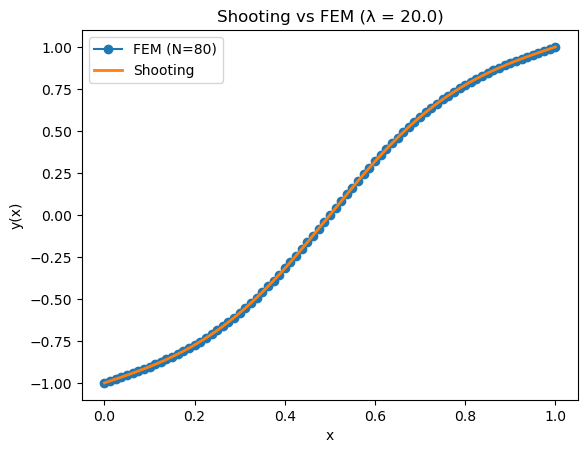

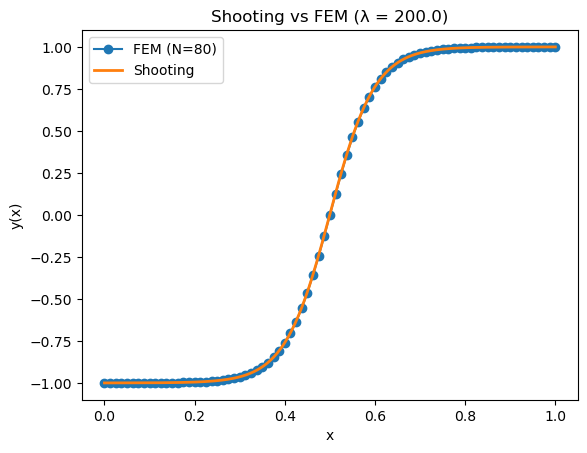

In [7]:
####### Run Shooting–FEM comparison (2 lamdas) #######

compare_shooting_vs_fem(lam=20.0, N=80)
compare_shooting_vs_fem(lam=200.0, N=80)

In this part of the implementation we test the robustness of both solvers across a range of parameter values. The nonlinear term $ \lambda (y^3 - y) $ becomes increasingly stiff as $ \lambda $ grows, so it is important to check whether each numerical method continues to converge when the equation becomes harder to solve. To study this, I define a routine that loops over a list of $ \lambda $ values and attempts to compute a solution using the shooting method and the FEM solver.

For each value of $ \lambda $, the function checks for errors during the numerical integration or during the nonlinear FEM iterations. If either solver fails to converge or raises an exception, the code records that outcome. This provides a simple validation step that confirms which methods remain stable for the ranges of $ \lambda $ relevant to the problem. The summary table printed at the end allows a quick comparison between the two approaches and helps identify when stiffness affects one solver more than the other.

In [9]:
####### Lambda Sweep Function  #######

# Sweep over a list of lambda values and test robustness
def sweep_lambda_values(lam_list, N=80, y_left=-1.0, y_right=1.0):
    """
    Try running both shooting and FEM for each lambda in lam_list
    Report success or failure
    """

    results = []

    for lam in lam_list:
        print(f"\nTesting λ = {lam} ...")

        # test shooting
        shooting_success = True
        try:
            x_s, y_s = solve_shooting_toy_bvp(lam=lam, y_left=y_left, y_right=y_right)
        except Exception as e:
            shooting_success = False
            print(f"  Shooting failed: {e}")

        # test FEM
        fem_success = True
        try:
            x_f, y_f = solve_fem_toy_bvp(lam=lam, N=N, y_left=y_left, y_right=y_right)
        except Exception as e:
            fem_success = False
            print(f"  FEM failed: {e}")

        results.append((lam, shooting_success, fem_success))

    # print summary table
    print("\nSummary:")
    for lam, s_ok, f_ok in results:
        print(f"λ={lam:>5}   Shooting={'OK' if s_ok else 'FAIL'}   FEM={'OK' if f_ok else 'FAIL'}")


Across all tested values from $ \lambda = 5 $ to $ \lambda = 300 $, both methods produced solutions without failure, which suggests that the implementations remain stable and consistent even as the nonlinearity increases.

In [11]:
####### Run Lambda Sweep (8 values)  #######

lam_list = [5, 10, 20, 50, 100, 150, 200, 300]
sweep_lambda_values(lam_list, N=80)


Testing λ = 5 ...

Testing λ = 10 ...

Testing λ = 20 ...

Testing λ = 50 ...

Testing λ = 100 ...

Testing λ = 150 ...

Testing λ = 200 ...

Testing λ = 300 ...

Summary:
λ=    5   Shooting=OK   FEM=OK
λ=   10   Shooting=OK   FEM=OK
λ=   20   Shooting=OK   FEM=OK
λ=   50   Shooting=OK   FEM=OK
λ=  100   Shooting=OK   FEM=OK
λ=  150   Shooting=OK   FEM=OK
λ=  200   Shooting=OK   FEM=OK
λ=  300   Shooting=OK   FEM=OK


In the next part of our implementation, we study how the nonlinear FEM solver behaves when we change the mesh resolution. Our aim is to see how many Newton iterations are required before the method reaches the stopping tolerance. This gives us a direct way to understand the cost of solving the nonlinear system and how it changes with the parameter $ \lambda $.

We begin by adapting our FEM routine so that it records the number of Newton updates taken during the solve. The update count increases each time the algorithm forms the residual, builds a Jacobian through finite differences, and solves the associated linear system. Once the residual norm falls below the tolerance, we stop the loop and return the solution together with the number of iterations.

After building this version of the solver, we run it for several mesh sizes. This lets us observe whether refinement makes the nonlinear solve more difficult. We then repeat the experiment at a larger value of $ \lambda $ to see how stiffness influences convergence. This study verifies part of our implemen

In [14]:
####### FEM With Newton Counter + Study Function #######

# FEM with Newton iteration counter
def fem_with_newton_count(lam=20.0, N=80, y_left=-1.0, y_right=1.0):
    """
    Solve FEM and return (x, y, newton_iterations)
    """
    # modify solve_fem_toy_bvp to track iteration count
    # easiest is to copy the function and add a counter.

    newton_count = 0

    # domain length
    L = 1.0

    # uniform grid
    x = np.linspace(0.0, L, N + 1)
    h = L / N

    # stiffness matrix
    K = np.zeros((N + 1, N + 1))
    for e in range(N):
        Ke = (1.0 / h) * np.array([[1.0, -1.0], [-1.0, 1.0]])
        K[e:e+2, e:e+2] += Ke

    K_int = K[1:N, 1:N]

    # nonlinear load
    def assemble_F_int(y_full):
        F_full = np.zeros(N + 1)
        for e in range(N):
            y_mid = 0.5*(y_full[e] + y_full[e+1])
            f_mid = -lam * (y_mid**3 - y_mid)
            F_full[e]     += 0.5 * h * f_mid
            F_full[e + 1] += 0.5 * h * f_mid
        return F_full[1:N]

    # residual
    def residual(u):
        y_full = np.zeros(N + 1)
        y_full[0] = y_left
        y_full[N] = y_right
        y_full[1:N] = u

        R_int = K_int @ u
        R_int[0] += (-1.0/h)*y_left
        R_int[-1] += (-1.0/h)*y_right

        F_int = assemble_F_int(y_full)
        return R_int - F_int

    # Jacobian via finite differences
    def jacobian_fd(u, eps=1e-6):
        R0 = residual(u)
        m = len(u)
        J = np.zeros((m, m))
        for j in range(m):
            u_pert = u.copy()
            u_pert[j] += eps
            Rj = residual(u_pert)
            J[:, j] = (Rj - R0) / eps
        return J

    # initial guess
    u = np.linspace(y_left, y_right, N + 1)[1:N]

    # Newton iteration loop
    for k in range(20):
        newton_count += 1

        R = residual(u)
        if np.linalg.norm(R) < 1e-8:
            break

        J = jacobian_fd(u)
        delta = np.linalg.solve(J, -R)
        u = u + delta

    # reconstruct full solution
    y_full = np.zeros(N + 1)
    y_full[0] = y_left
    y_full[N] = y_right
    y_full[1:N] = u

    return x, y_full, newton_count

# Collect Newton iteration count vs mesh size
def newton_iteration_study(lam=20.0, mesh_list=[20,40,80,160]):
    counts = []
    for N in mesh_list:
        print(f"Running FEM at N = {N}")
        _, _, n_iter = fem_with_newton_count(lam=lam, N=N)
        counts.append(n_iter)
        print(f"  Newton iterations: {n_iter}")
    return mesh_list, counts



For λ = 20, the number of Newton iterations stays constant at five across all mesh sizes. This shows that the nonlinear solve does not become harder as the grid is refined and that the FEM residual and Jacobian are behaving in a stable way.

For λ = 200, the solver requires more Newton steps, especially on coarse meshes. As N increases, the iteration count decreases from about twenty to thirteen, which indicates that the strong nonlinearity is easier to resolve once the mesh is fine enough to capture the steep transition in the solution.

Running FEM at N = 20
  Newton iterations: 5
Running FEM at N = 40
  Newton iterations: 5
Running FEM at N = 80
  Newton iterations: 5
Running FEM at N = 160
  Newton iterations: 5


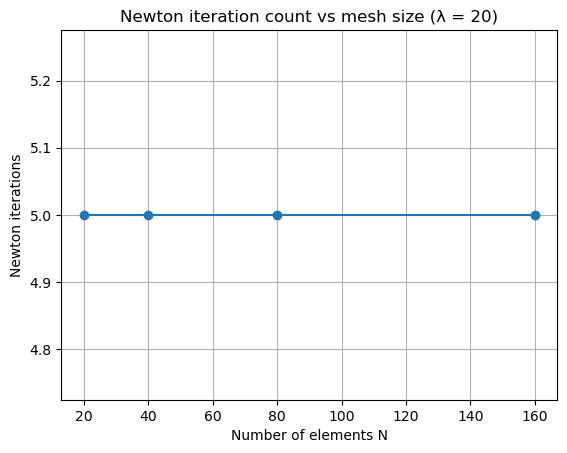

Running FEM at N = 20
  Newton iterations: 20
Running FEM at N = 40
  Newton iterations: 20
Running FEM at N = 80
  Newton iterations: 14
Running FEM at N = 160
  Newton iterations: 13


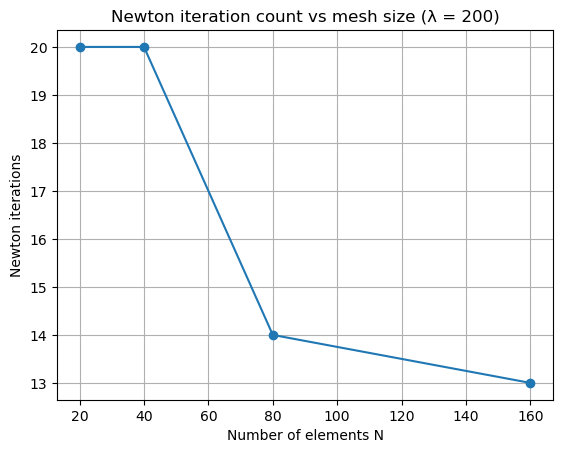

In [18]:
####### Run Newton Counter (2 values)  #######

# λ = 20 (non-stiff)
mesh_list = [20, 40, 80, 160]
N_list_newton, newton_counts = newton_iteration_study(lam=20.0, mesh_list=mesh_list)
plt.figure()
plt.plot(N_list_newton, newton_counts, "o-")
plt.xlabel("Number of elements N")
plt.ylabel("Newton iterations")
plt.title("Newton iteration count vs mesh size (λ = 20)")
plt.grid(True)
plt.show()

# λ = 200 (stiff)
mesh_list_stiff = [20, 40, 80, 160]
N_list_newton_stiff, newton_counts_stiff = newton_iteration_study(lam=200.0, mesh_list=mesh_list_stiff)
plt.figure()
plt.plot(N_list_newton_stiff, newton_counts_stiff, "o-")
plt.xlabel("Number of elements N")
plt.ylabel("Newton iterations")
plt.title("Newton iteration count vs mesh size (λ = 200)")
plt.grid(True)
plt.show()

In the next part of the implementation, we check whether our FEM solver converges under mesh refinement.   To do this, we use the shooting solution as a reference since it solves the same boundary value problem with a very fine step size.  

We compute the FEM solution for several mesh sizes, interpolate each FEM result onto the reference grid, and then measure the L2 error between the two solutions. This gives a direct way to see how the discretization error behaves as N increases.

In [25]:
####### Convergence Study #######

# Compute FEM convergence vs mesh size, using shooting as reference
def fem_convergence_study(lam=20.0, y_left=-1.0, y_right=1.0, mesh_list=[20, 40, 80, 160, 320]):
    """
    For each mesh size in mesh_list, solve the toy BVP with FEM and compute the error against the shooting solution
    Returns (mesh_list, error_list)
    """

    # compute reference solution once using shooting
    x_ref, y_ref = solve_shooting_toy_bvp(lam=lam, y_left=y_left, y_right=y_right)
    # list to store errors
    error_list = []

    # loop over mesh sizes
    for N in mesh_list:
        print(f"Solving FEM with N = {N}")

        # FEM solution
        x_fem, y_fem = solve_fem_toy_bvp(lam=lam, N=N, y_left=y_left, y_right=y_right)

        # interpolate FEM solution to reference x-grid
        y_fem_interp = np.interp(x_ref, x_fem, y_fem)

        # compute L2 error norm
        err = np.sqrt(np.trapz((y_fem_interp - y_ref)**2, x_ref))
        error_list.append(err)

        print(f"  Error = {err:.3e}")

    return mesh_list, error_list


# Plot convergence curve
def plot_fem_convergence(mesh_list, error_list, lam=20.0):
    """
    Plot error vs mesh size on log scale.
    """

    plt.figure()
    plt.loglog(mesh_list, error_list, "o-", linewidth=2)
    plt.xlabel("Number of elements N")
    plt.ylabel("L2 error norm")
    plt.title(f"FEM Convergence vs Mesh Size (λ = {lam})")
    plt.grid(True, which="both")
    plt.show()

The convergence curve shows a steady decrease in the $L^2$ error as N increases. The error decays nearly linearly on the log scale, which indicates that the FEM implementation is consistent and convergent for this nonlinear problem. The trend also confirms that the shooting solution is a reliable reference for measuring accuracy.

Solving FEM with N = 20
  Error = 1.125e-03
Solving FEM with N = 40
  Error = 2.819e-04
Solving FEM with N = 80
  Error = 7.054e-05
Solving FEM with N = 160
  Error = 1.762e-05
Solving FEM with N = 320
  Error = 4.409e-06


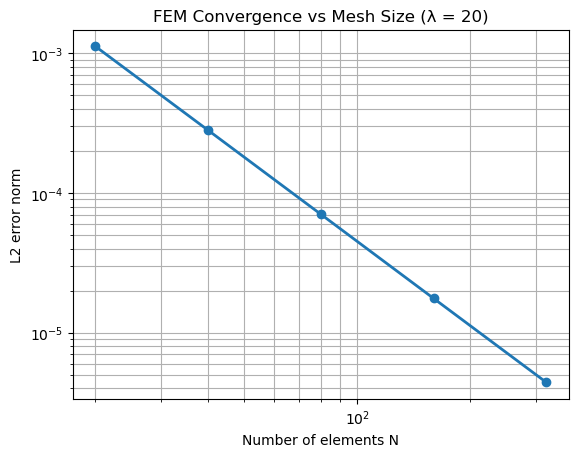

In [27]:
####### Run Newton Counter (1 value - 20)  #######

mesh_sizes = [20,40,80,160,320]
N_list, err_list = fem_convergence_study(lam=20, mesh_list=mesh_sizes)
plot_fem_convergence(N_list, err_list, lam=20)

**Computational component #4**

We implement a simple one-dimensional finite element method (FEM) for the nonlinear boundary value problem  
$$u''(x) = \lambda \left( u(x)^3 - u(x) \right), \qquad u(0) = -1,\; u(1) = 1.$$

We discretize the domain into $N$ linear elements and construct the residual vector and Jacobian by evaluating  
$$R_i = \int_0^1 \left( u'(x) v_i'(x) - \lambda (u(x)^3 - u(x)) v_i(x) \right)\,dx,\text{ } J_{ij} = \frac{\partial R_i}{\partial u_j}.$$  

We assemble these element contributions into a global system $R(U)=0$ and apply Newton's method until convergence. This FEM routine provides one of our two “ground truth” numerical solvers. To check correctness, we run a convergence study by refining $N$ and computing the $L^2$ error norm between the FEM solution computed at coarse $N$ and a finer reference solution.  

**Computational component #5**

We implement a shooting method for the same boundary value problem. We rewrite the second-order equation as a first-order system $$y_1' = y_2, \qquad y_2' = \lambda (y_1^3 - y_1).$$  

We impose the left boundary condition $y_1(0)=-1$ and treat the initial slope $y_2(0)=s$ as an unknown. For each trial value of $s$ we integrate the system with `solve_ivp` to $x=1$ and compute the mismatch  
$$F(s)=y_1(1;s)-1.$$ We update $s$ with Newton iteration until $F(s)=0$, giving a shooting solution that satisfies both boundary conditions.  

We then compare the FEM and shooting solutions across several values of $\lambda$ to verify consistency between the two independent numerical methods.